# phase 3

# loading the dataset

In [10]:
import numpy as np
import pandas as pd

In [4]:
df=pd.read_csv("C://Users//ADMIN//Downloads//diabetes.csv");
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [41]:
%matplotlib inline
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import os
import scipy.ndimage
Downloads = '../input/sample_images/'
patients = os.listdir("C:/Users/ADMIN/Downloads")
patients.sort()


In [42]:
def load_scan(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir("C:/Users/ADMIN/Downloads")]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

In [43]:
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    
    image = image.astype(np.int16)

    
    image[image == -2000] = 0
    
    
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

# preprocessing the dataset

# Resampling


In [38]:
def resample(image, scan, new_spacing=[1,1,1]):
    spacing = np.array([scan[0].SliceThickness] + scan[0].PixelSpacing, dtype=np.float32)

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    return image, new_spacing

In [ ]:
pix_resampled, spacing = resample(first_patient_pixels, first_patient, [1,1,1])
print("Shape before resampling\t", first_patient_pixels.shape)
print("Shape after resampling\t", pix_resampled.shape)

Shape before resampling	 (134, 512, 512)
Shape after resampling	 (335, 306, 306)

# Normalization

In [52]:
MIN_BOUND = -1000.0
MAX_BOUND = 400.0
    
def normalize(image):
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image>1] = 1.
    image[image<0] = 0.
    return image

# Zero centering

In [53]:
PIXEL_MEAN = 0.25

def zero_center(image):
    image = image - PIXEL_MEAN
    return image

# Data Analysis

In [55]:
import seaborn as sns
import time


In [56]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [57]:
col = df.columns      
print(col)

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')


In [62]:
y = df.Pregnancies                          
list = ['Pregnancies','BloodPressure']
x = df.drop(list,axis = 1 )
x.head()

,Glucose,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,148,35,0,33.6,0.627,50,1
1,85,29,0,26.6,0.351,31,0
2,183,0,0,23.3,0.672,32,1
3,89,23,94,28.1,0.167,21,0
4,137,35,168,43.1,2.288,33,1


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


ValueError: too many values to unpack (expected 2)

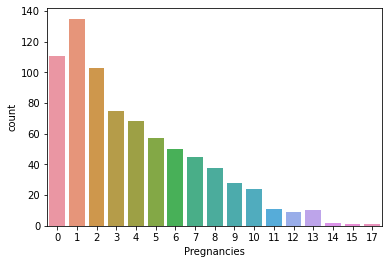

In [63]:
ax = sns.countplot(y,label="Count")       
B, M = y.value_counts()
print('Number of Benign: ',B)
print('Number of Malignant : ',M)

In [64]:
x.describe()

,Glucose,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,120.894531,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,31.972618,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,99.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,117.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,140.250000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,199.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [65]:
df.dropna()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


# Feature selection

# Feature selection with correlation and random forest classification

In [83]:
drop_list1 = ['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction	','Age','Outcome']
x = drop_list1        


In [80]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.metrics import accuracy_score


Accuracy is:  0.18181818181818182


<AxesSubplot:>

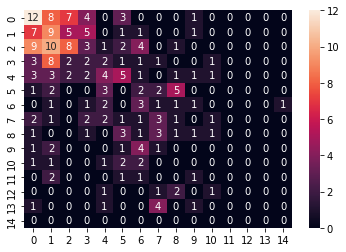

In [81]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

clf_rf = RandomForestClassifier(random_state=43)      
clr_rf = clf_rf.fit(x_train,y_train)

ac = accuracy_score(y_test,clf_rf.predict(x_test))
print('Accuracy is: ',ac)
cm = confusion_matrix(y_test,clf_rf.predict(x_test))
sns.heatmap(cm,annot=True,fmt="d")

<AxesSubplot:>

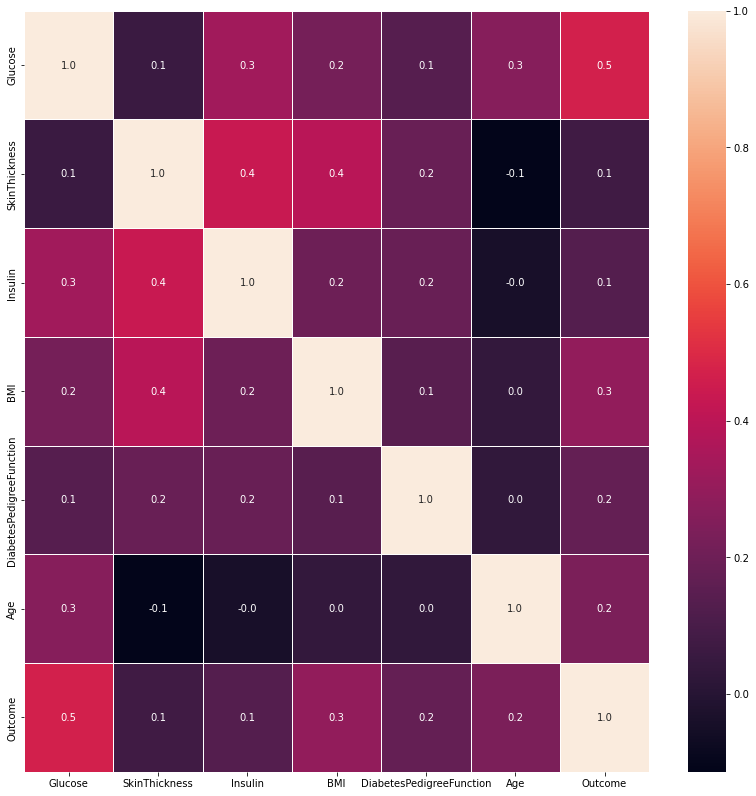

In [82]:
#correlation map
f,ax = plt.subplots(figsize=(14, 14))
sns.heatmap(x.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

# Univariate feature selection and random forest classification¶


In [86]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
# find best scored 5 features
select_feature = SelectKBest(chi2, k=5).fit(x_train, y_train)

In [87]:
print('Score list:', select_feature.scores_)
print('Feature list:', x_train.columns)

Score list: [3.22855360e+02 3.36987371e+02 3.35972385e+03 5.21171714e+01
 2.91679024e+00 7.60989925e+02 3.21167519e+01]
Feature list: Index(['Glucose', 'SkinThickness', 'Insulin', 'BMI',
       'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')


Accuracy is:  0.18614718614718614


<AxesSubplot:>

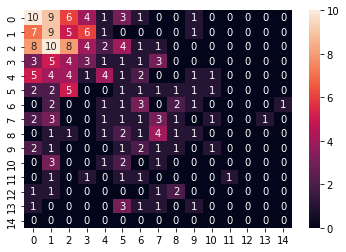

In [88]:
x_train_2 = select_feature.transform(x_train)
x_test_2 = select_feature.transform(x_test)
#random forest classifier with n_estimators=10 (default)
clf_rf_2 = RandomForestClassifier()      
clr_rf_2 = clf_rf_2.fit(x_train_2,y_train)
ac_2 = accuracy_score(y_test,clf_rf_2.predict(x_test_2))
print('Accuracy is: ',ac_2)
cm_2 = confusion_matrix(y_test,clf_rf_2.predict(x_test_2))
sns.heatmap(cm_2,annot=True,fmt="d")

# Recursive feature elimination (RFE) with random forest


In [90]:
from sklearn.feature_selection import RFE
# Create the RFE object and rank each pixel
clf_rf_3 = RandomForestClassifier()      
rfe = RFE(estimator=clf_rf_3, n_features_to_select=5, step=1)
rfe = rfe.fit(x_train, y_train)

In [91]:
print('Chosen best 5 feature by rfe:',x_train.columns[rfe.support_])


Chosen best 5 feature by rfe: Index(['Glucose', 'SkinThickness', 'BMI', 'DiabetesPedigreeFunction', 'Age'], dtype='object')


# Recursive feature elimination with cross validation and random forest classification

In [ ]:
from sklearn.feature_selection import RFECV

# The "accuracy" scoring is proportional to the number of correct classifications
clf_rf_4 = RandomForestClassifier() 
rfecv = RFECV(estimator=clf_rf_4, step=1, cv=5,scoring='accuracy')   #5-fold cross-validation
rfecv = rfecv.fit(x_train, y_train)

print('Optimal number of features :', rfecv.n_features_)
print('Best features :', x_train.columns[rfecv.support_])
Optimal number of features : 10
Best features : Index(['texture_mean', 'area_mean', 'smoothness_mean', 'concavity_mean',
       'area_se', 'concavity_se', 'fractal_dimension_se', 'smoothness_worst',
       'concavity_worst', 'symmetry_worst'],
      dtype='object')

# Tree based feature selection and random forest classification


Feature ranking:
1. feature 5 (0.192603)
2. feature 3 (0.190476)
3. feature 4 (0.183606)
4. feature 0 (0.175378)
5. feature 1 (0.128981)
6. feature 2 (0.100185)
7. feature 6 (0.028771)


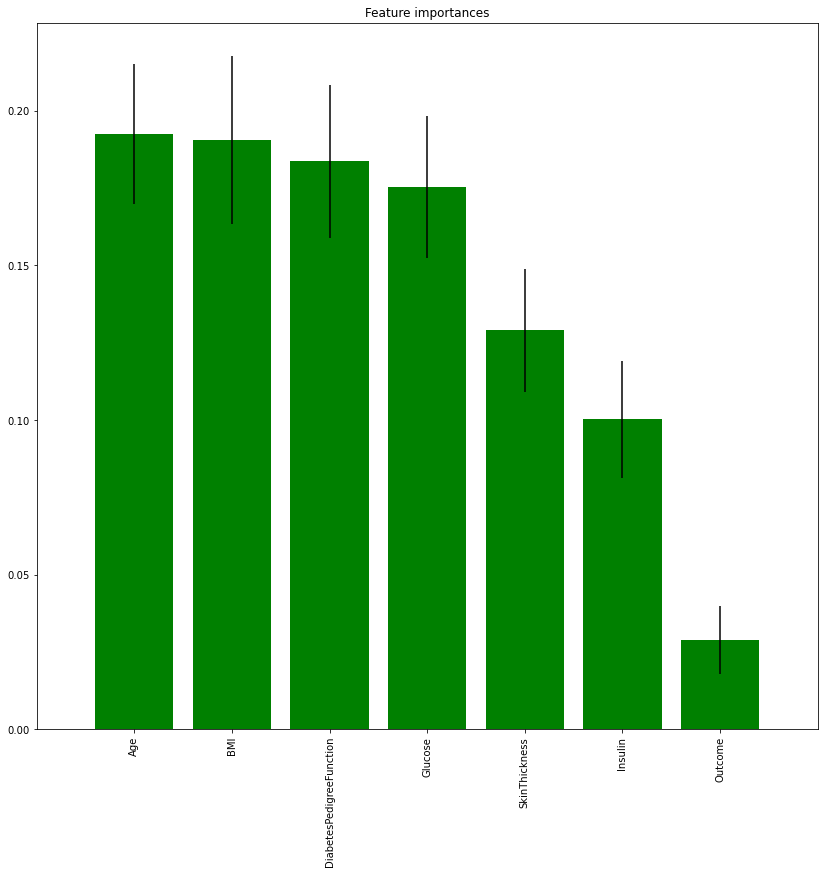

In [95]:
clf_rf_5 = RandomForestClassifier()      
clr_rf_5 = clf_rf_5.fit(x_train,y_train)
importances = clr_rf_5.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(x_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest

plt.figure(1, figsize=(14, 13))
plt.title("Feature importances")
plt.bar(range(x_train.shape[1]), importances[indices],
       color="g", yerr=std[indices], align="center")
plt.xticks(range(x_train.shape[1]), x_train.columns[indices],rotation=90)
plt.xlim([-1, x_train.shape[1]])
plt.show()